In [2]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell1D.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

Downloaded utils.py
Downloaded Cell1D.py
Downloaded Cell2D.py


In [47]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

In [48]:
from Cell1D import Cell1D, draw_ca

In [49]:
class Wrap1D(Cell1D):
    """Implements a 1D cellular automaton with wrapping."""

    def step(self):
        # perform the usual step operation
        Cell1D.step(self)

        # fix the first and last cells by copying from the other end
        i = self.next-1
        row = self.array[i]
        row[0], row[-1] = row[-2], row[1]   

In [50]:
def count_cells(rule, n=128):
    """Make a CA and count cells.
    
    rule: int rule number
    n: number of steps reflects EEG channel number
    """
    ca = Wrap1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

In [51]:
from scipy.stats import linregress

def test_fractal(rule):
    res = count_cells(rule)
    steps, steps2, cells = np.transpose(res)

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

In [52]:
d = {}
for rule in range(128):
    slope = test_fractal(rule)
    if slope > 1.1 and slope < 1.9:
        slope = np.around(slope, 3)
        if slope not in d:
            d[slope] = rule

In [53]:
def value_sorted(d):
    return sorted(d.items(), key=lambda x: x[1])

In [54]:
rules = []
for slope, rule in value_sorted(d):
    print(rule, slope)
    rules.append(rule)

len(rules)

1 1.192
9 1.191
18 1.566
22 1.582
28 1.819
30 1.895
45 1.19
73 1.161
75 1.195
78 1.792
91 1.193
94 1.871
105 1.166
109 1.214
110 1.811
126 1.625


16

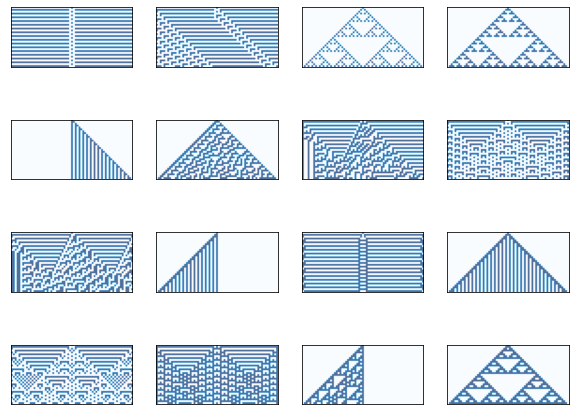

In [55]:
plt.figure(figsize=(10, 10))

for i, rule in enumerate(rules):
    plt.subplot(5, 4, i+1)
    draw_ca(rule)

In [56]:
# Here's the color map I used

from matplotlib.colors import LinearSegmentedColormap
colors = [(0,   'white'),
          (0.2, 'Green'),
          (1.0, 'Orange')]
    
cmap = LinearSegmentedColormap.from_list('mycmap', colors)






In [57]:
from scipy.signal import correlate2d
from Cell2D import Cell2D
from Cell2D import Cell2D, draw_array


In [58]:
class ForestFire(Cell2D):

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, p=0.01, f=0.001):

        self.p = p
        self.f = f
        
        self.array = np.random.choice([1, 0], (n, n), p=[p, 1-p])

    def step(self):
        p, f = self.p, self.f
        a = self.array
        c = correlate2d(a, self.kernel, mode='same', boundary='wrap')
        r = np.random.random(a.shape)
        new_tree = (a==0) & (r<p)
        new_fire = (a==1) & ((c>4) | (r<f))
        a[a==5] = 0
        a[new_tree] = 1
        a[new_fire] = 5
        
    def num_trees(self, i=None):
        a = self.array[:i, :i]
        return np.sum(a==1)
        
    def num_fires(self, i=None):
        a = self.array[:i, :i]
        return np.sum(a==5)
    
    def draw(self):
        draw_array(self.array, cmap=cmap, vmax=5)

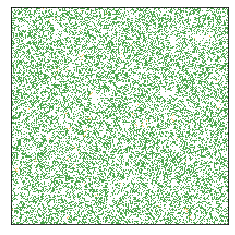

In [59]:
fire = ForestFire(200)
fire.animate(frames=50)

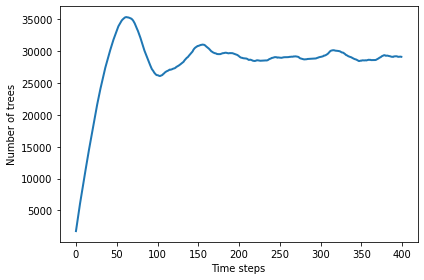

In [60]:
np.random.seed(128)
fire = ForestFire(300)
num_trees = []
for i in range(400):
    fire.step()
    num_trees.append(fire.num_trees())
    
plt.plot(num_trees)
decorate(xlabel='Time steps',
         ylabel='Number of trees')

In [61]:
res = []
sizes = range(10, 100)
for i in sizes:
    res.append((i**2, fire.num_trees(i), fire.num_fires(i)))

In [62]:
cells, trees, fires = np.transpose(res)

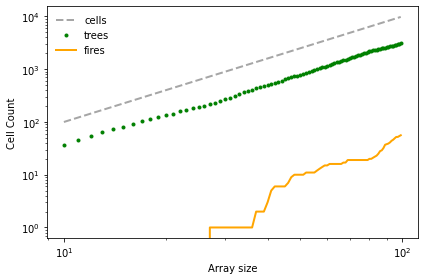

In [63]:
options = dict(linestyle='dashed', color='gray', alpha=0.7)
plt.plot(sizes, cells, label='cells', **options)
plt.plot(sizes, trees, '.', label='trees', color='green')
plt.plot(sizes, fires, label='fires', color='orange')
decorate(xlabel='Array size',
         ylabel='Cell Count',
         xscale='log', xlim=None, 
         yscale='log', ylim=None,
         loc='upper left')

In [64]:
from scipy.stats import linregress

for ys in [cells, trees]:
    params = linregress(np.log(sizes), np.log(ys))
    print(params[0])

2.0000000000000004
1.9732562939867964
